# Batch BO Runs for Multiple Fingerprint Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import SmilesToDescriptors, plot_results

# ─── BayBE imports (one-time) ─────────────────────────────────────────────
from baybe.parameters import CustomDiscreteParameter
from baybe.searchspace import SearchSpace
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender, FPSRecommender,
    TwoPhaseMetaRecommender, RandomRecommender
)
# ──────────────────────────────────────────────────────────────────────────

# ─── Dataset pools ────────────────────────────────────────────────────────
df = pd.read_csv("dataset.csv")

reactant_1_pool  = df['reactant_1'].unique().tolist()
catalyst_1_pool  = df['catalyst_1'].unique().tolist()
catalyst_2_pool  = df['curated_catalyst_2'].unique().tolist()
# ──────────────────────────────────────────────────────────────────────────

# ─── Helper function to run one BO for a given descriptor method ──────────
def get_method_searchspace(method_name):
    # 1. build descriptor DataFrames
    r_desc  = SmilesToDescriptors(reactant_1_pool,  method=method_name)
    c1_desc = SmilesToDescriptors(catalyst_1_pool,  method=method_name)
    c2_desc = SmilesToDescriptors(catalyst_2_pool,  method=method_name)

    # 2. wrap each in a CustomDiscreteParameter
    p_r  = CustomDiscreteParameter(name="reactant_1",         data=r_desc,  decorrelate=0.7)
    p_c1 = CustomDiscreteParameter(name="catalyst_1",         data=c1_desc, decorrelate=0.7)
    p_c2 = CustomDiscreteParameter(name="curated_catalyst_2",         data=c2_desc, decorrelate=0.7)

    parameters  = [p_r, p_c1, p_c2]
    searchspace = SearchSpace.from_product(parameters)

    # 3. build target + objective once
    target     = NumericalTarget(name='ee_R', mode="MAX")
    objective  = SingleTargetObjective(target=target)

    return searchspace
# ──────────────────────────────────────────────────────────────────────────


In [3]:
METHODS = ['Morgan', 'RDK', 'EState', 'OneHot']

# ─── Global BO settings ───────────────────────────────────────────────────
BATCH_SIZE       = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS  = 5

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),
    recommender=BotorchRecommender(),
    switch_after=10,
)
random_recommender = RandomRecommender()

lookup = df[['reactant_1', 'catalyst_1', 'curated_catalyst_2', 'ee_R']]
# ──────────────────────────────────────────────────────────────────────────

objective = SingleTargetObjective(
    target=NumericalTarget(name='ee_R', mode="MAX")
)

rdm_campaign = Campaign(get_method_searchspace('EState'), objective, random_recommender)

scenario = {method:Campaign(get_method_searchspace(method), objective, botorch_fps_recommender) for method in METHODS}
scenario['Random'] = rdm_campaign


results = simulate_scenarios(
    scenario,
    lookup,
    batch_size       = BATCH_SIZE,
    n_doe_iterations = N_DOE_ITERATIONS,
    n_mc_iterations  = N_MC_ITERATIONS,
)

                            EState_1 EState_2 EState_3 EState_4 EState_5  \
c1ccc(C(=O)CBr)cc1               NaN      NaN      NaN      NaN      NaN   
Cc1ccc(C(=O)CBr)cc1              NaN      NaN      NaN      NaN      NaN   
Oc1ccc(C(=O)CBr)cc1              NaN      NaN      NaN      NaN      NaN   
COc1ccc(C(=O)CBr)cc1             NaN      NaN      NaN      NaN      NaN   
c2ccccc2c1ccc(C(=O)CBr)cc1       NaN      NaN      NaN      NaN      NaN   
FC(F)(F)c1ccc(C(=O)CBr)cc1       NaN      NaN      NaN      NaN      NaN   
Fc1ccc(C(=O)CBr)cc1              NaN      NaN      NaN      NaN      NaN   
Clc1ccc(C(=O)CBr)cc1             NaN      NaN      NaN      NaN      NaN   
Brc1ccc(C(=O)CBr)cc1             NaN      NaN      NaN      NaN      NaN   
FC(F)(F)Oc1ccc(C(=O)CBr)cc1      NaN      NaN      NaN      NaN      NaN   

                            EState_6 EState_7 EState_8 EState_9 EState_10  \
c1ccc(C(=O)CBr)cc1               NaN      NaN      NaN      NaN       NaN   
Cc1ccc(C(

AttributeError: 'NoneType' object has no attribute 'columns'

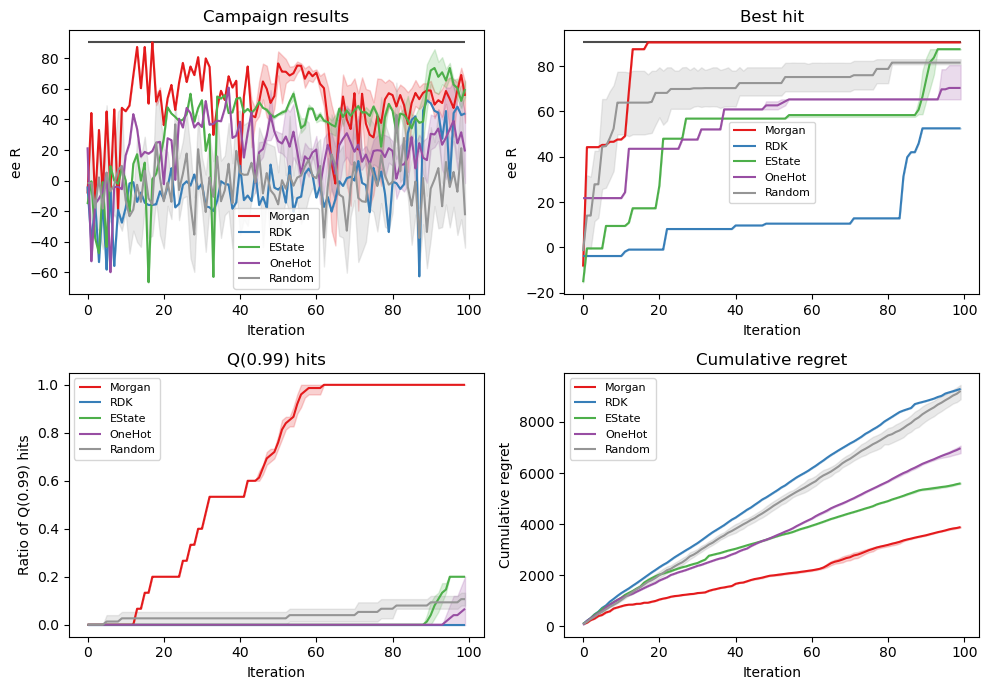

In [18]:
plot_results(results, lookup, figure_name=f"fingerprints.png", nbr_controls=1)